In [355]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [356]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sun Jul 24 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.3.0

sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
pandas    : 1.4.2
scipy     : 1.7.3
matplotlib: 3.5.2
arviz     : 0.12.1
numpy     : 1.22.4
pymc      : 4.0.0b1

Watermark: 2.3.0



In [357]:
def z(X):
    return ( (X - np.mean(X)) / np.std(X) ) 

In [358]:
data = pd.read_csv("Data/WaffleDivorce.csv", sep=";")

In [359]:
data.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78               25.3      20.2         1.27   
1      Alaska  AK        0.71               25.2      26.0         2.93   
2     Arizona  AZ        6.33               25.8      20.3         0.98   
3    Arkansas  AR        2.92               24.3      26.4         1.70   
4  California  CA       37.25               26.8      19.1         0.39   

   Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0     12.7        0.79           128      1      435080          964201   
1     12.5        2.05             0      0           0               0   
2     10.8        0.74            18      0           0               0   
3     13.5        1.22            41      1      111115          435450   
4      8.0        0.24             0      0           0          379994   

   PropSlaves1860  
0            0.45  
1            0.00  
2            0.00  
3            0.26  
4            0.00

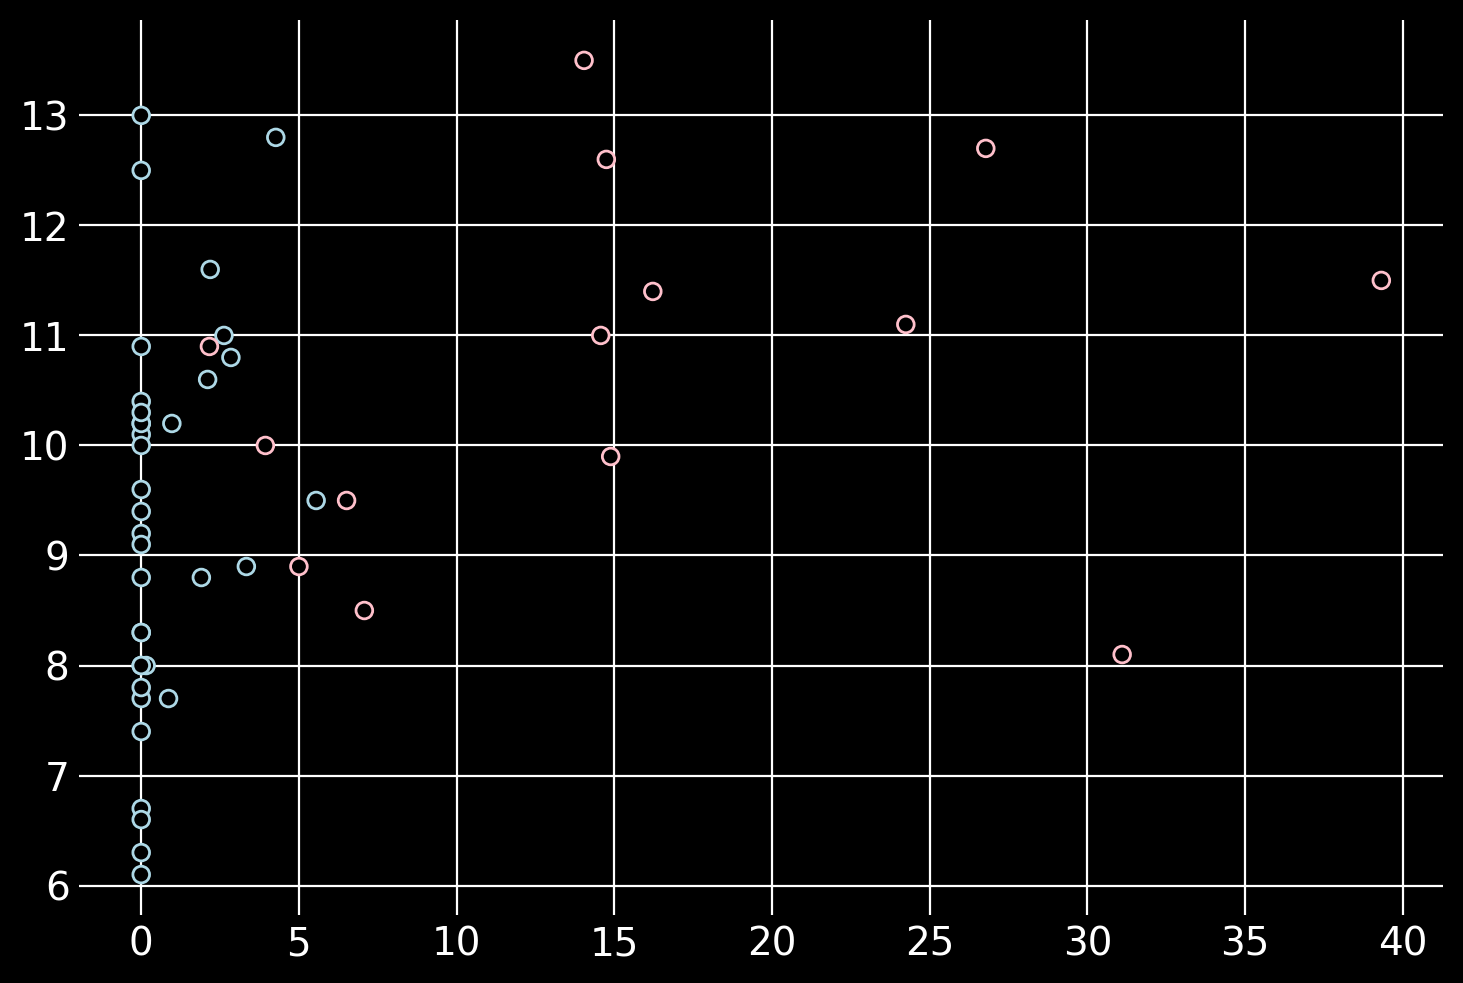

In [360]:
_, ax = plt.subplots()
ax.scatter(data["WaffleHouses"]/data["Population"], data["Divorce"], lw=1, color="black",
edgecolor = data["South"].map({1 : "pink", 0 : "lightblue"}))

In [361]:
## standardize the data

for x in ["Divorce", "Marriage", "MedianAgeMarriage"]:
    data[x + "_raw"] = data[x]
    data[x] = z(data[x])

data.head()


Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78          -0.612445  0.022874         1.27   
1      Alaska  AK        0.71          -0.693671  1.565536         2.93   
2     Arizona  AZ        6.33          -0.206314  0.049472         0.98   
3    Arkansas  AR        2.92          -1.424706  1.671927         1.70   
4  California  CA       37.25           0.605947 -0.269700         0.39   

    Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0  1.671000        0.79           128      1      435080          964201   
1  1.560044        2.05             0      0           0               0   
2  0.616916        0.74            18      0           0               0   
3  2.114824        1.22            41      1      111115          435450   
4 -0.936470        0.24             0      0           0          379994   

   PropSlaves1860  Divorce_raw  Marriage_raw  MedianAgeMarriage_raw  
0            0.45         12.7          20.2                   25.3  
1            0.00         12.5          26.0                   25.2  
2            0.00         10.8          20.3                   25.8  
3            0.26         13.5          26.4                   24.3  
4            0.00          8.0          19.1                   26.8

In [362]:
## .values converts to numpy array

medianAge = data["MedianAgeMarriage"].values
marRate = data["Marriage"].values
divObs = data["Divorce"].values

In [363]:
with pm.Model() as m5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bA * medianAge)
    div_rate = pm.Normal("div_rate", mu, s, observed=divObs)
    prior_samples = pm.sample_prior_predictive(samples=1000)
    trace5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, s]


/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bA'}>,
        <AxesSubplot:title={'center':'bA'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>]], dtype=object)

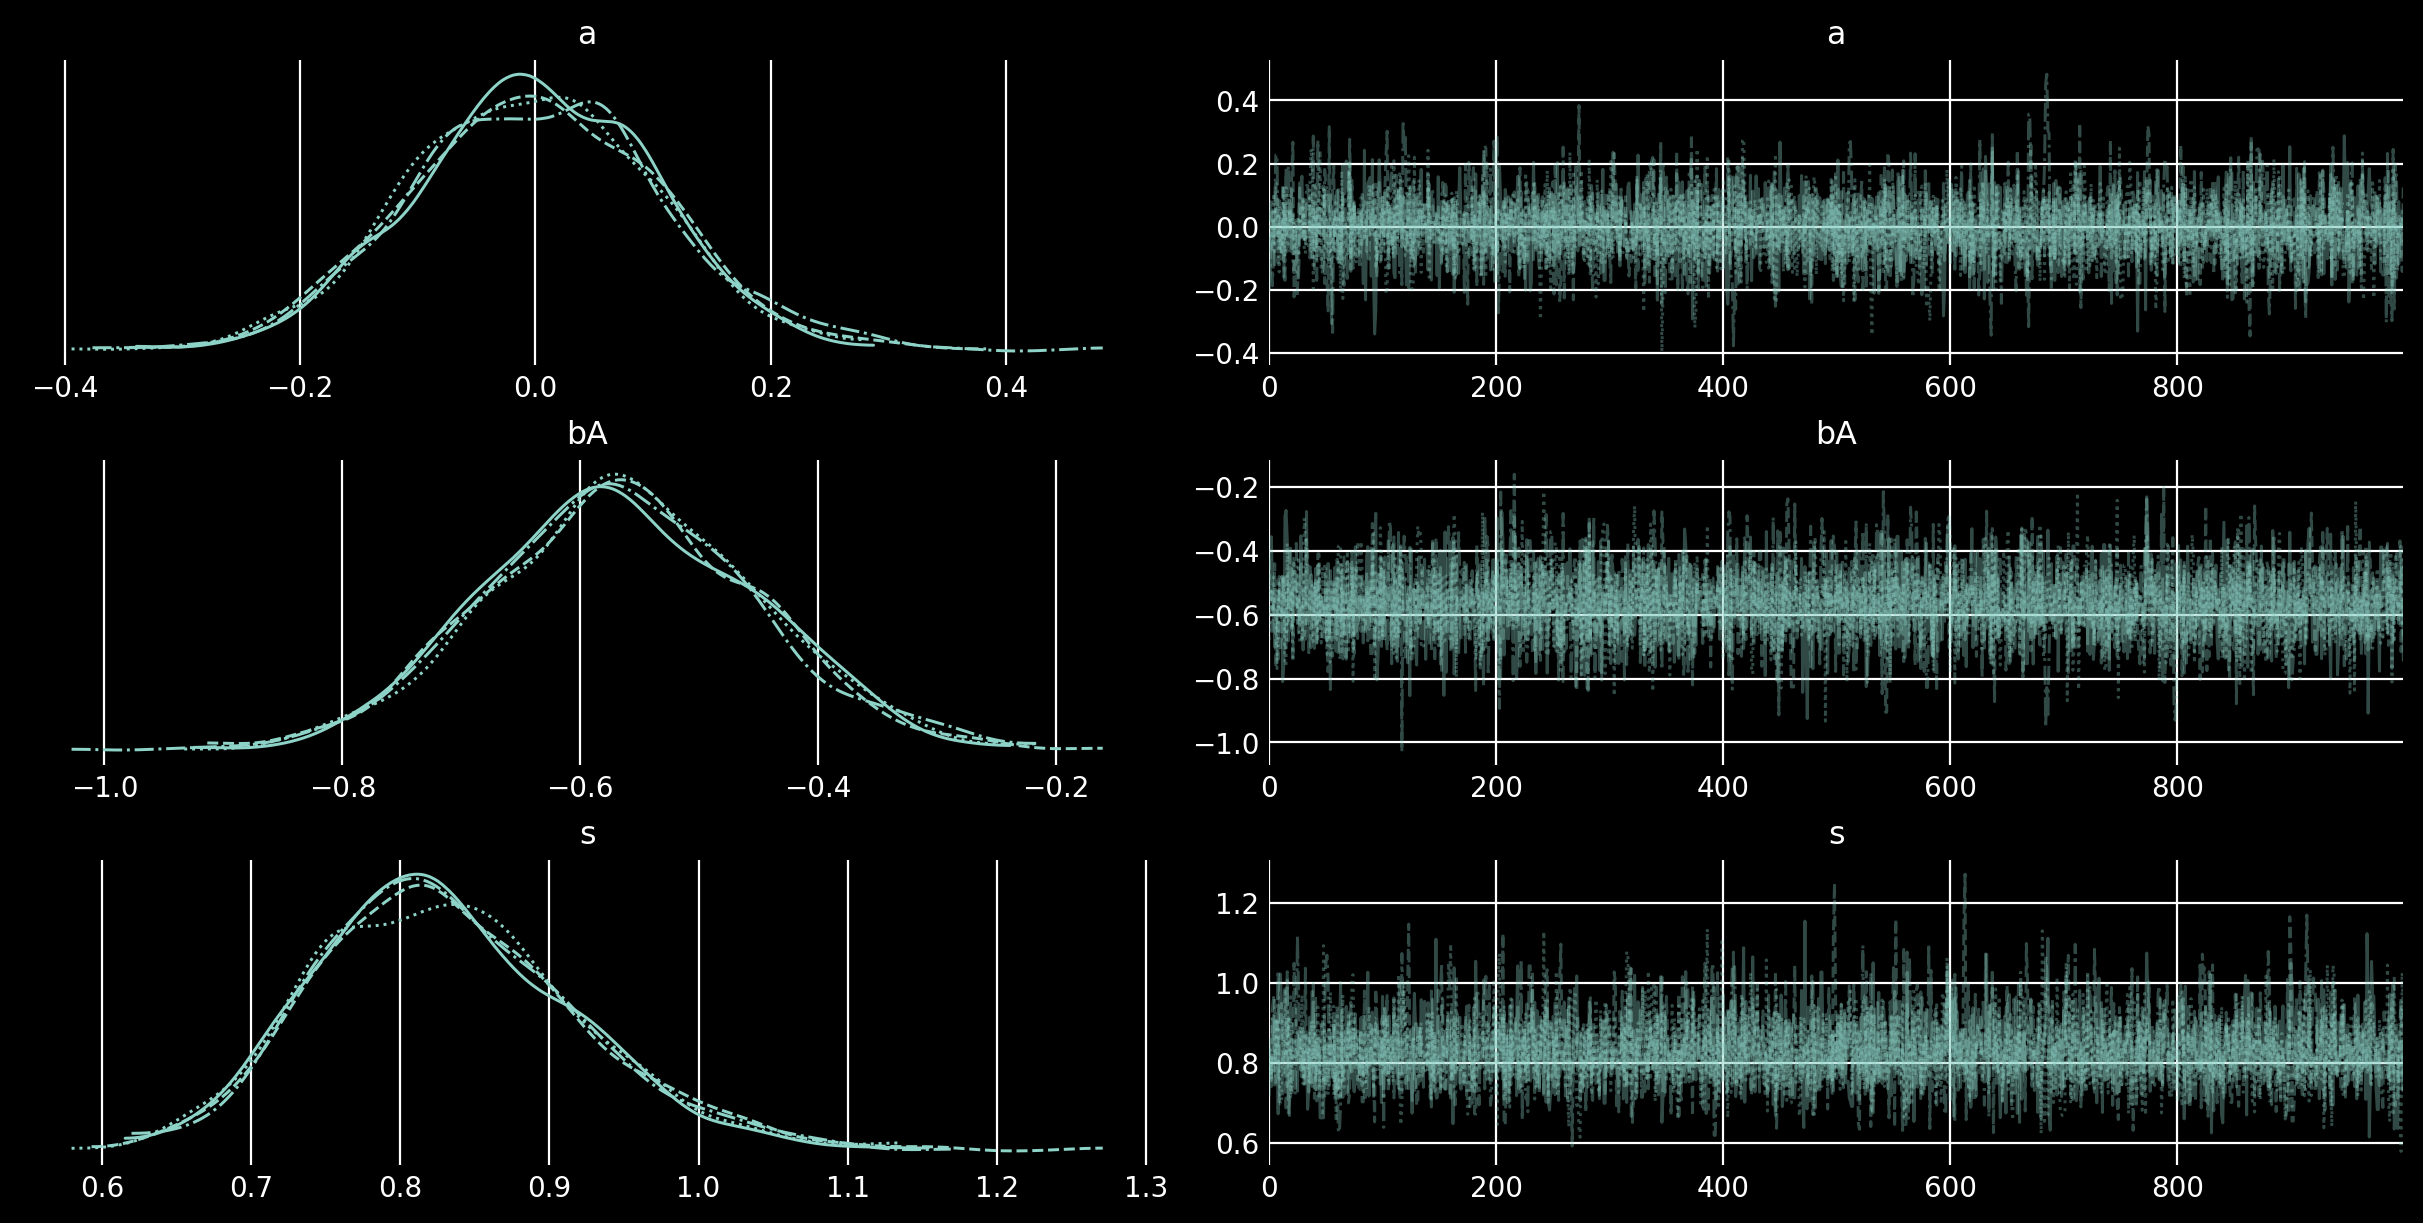

In [364]:
az.plot_trace(trace5_1, ["~mu"])

prior predictive

In [365]:
mu_prior = prior_samples.prior["mu"]
div_prior = prior_samples.prior_predictive["div_rate"]

# chain 0
apriors = np.array(prior_samples.prior["a"][0])
bApriors = np.array(prior_samples.prior["bA"][0])
mupriors = np.array(prior_samples.prior["mu"][0])



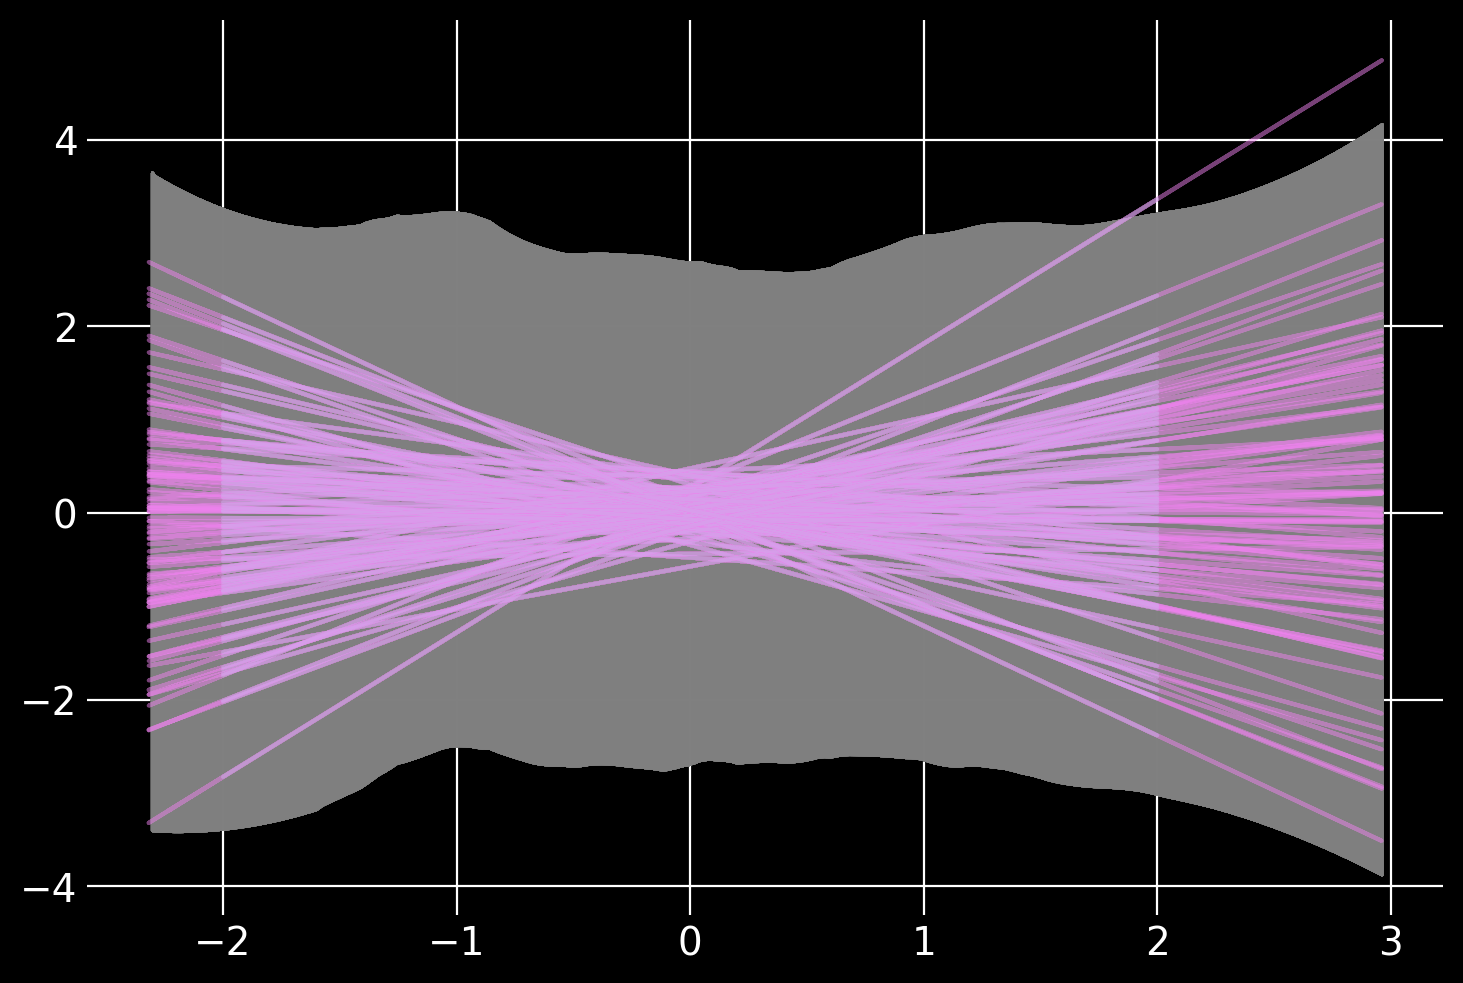

In [366]:
x = np.linspace(2,-2,50)

_,ax = plt.subplots()
for i in range(100):
    #using arbitrary x values
    ax.plot(x, apriors[i] + bApriors[i] * x, alpha=0.5, color="lightblue")
    #using prior samples (identical results)
    ax.plot(medianAge, mupriors[i], alpha=0.5, color="violet")
    az.plot_hdi(medianAge, div_prior, color="gray")


posterior predictive

In [367]:
mu_post = trace5_1.posterior["mu"]

#axis 0 = chain, axis 1 = sample
mu_mean = mu_post.mean(axis=(0,1))

post_samp = pm.sample_posterior_predictive(trace5_1, 1000, m5_1)
div_post_pred = post_samp.posterior_predictive["div_rate"]

/var/folders/8p/pvxyj07903v98z897cyy14cm0000gp/T/ipykernel_88647/3758450447.py:6: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  post_samp = pm.sample_posterior_predictive(trace5_1, 1000, m5_1)


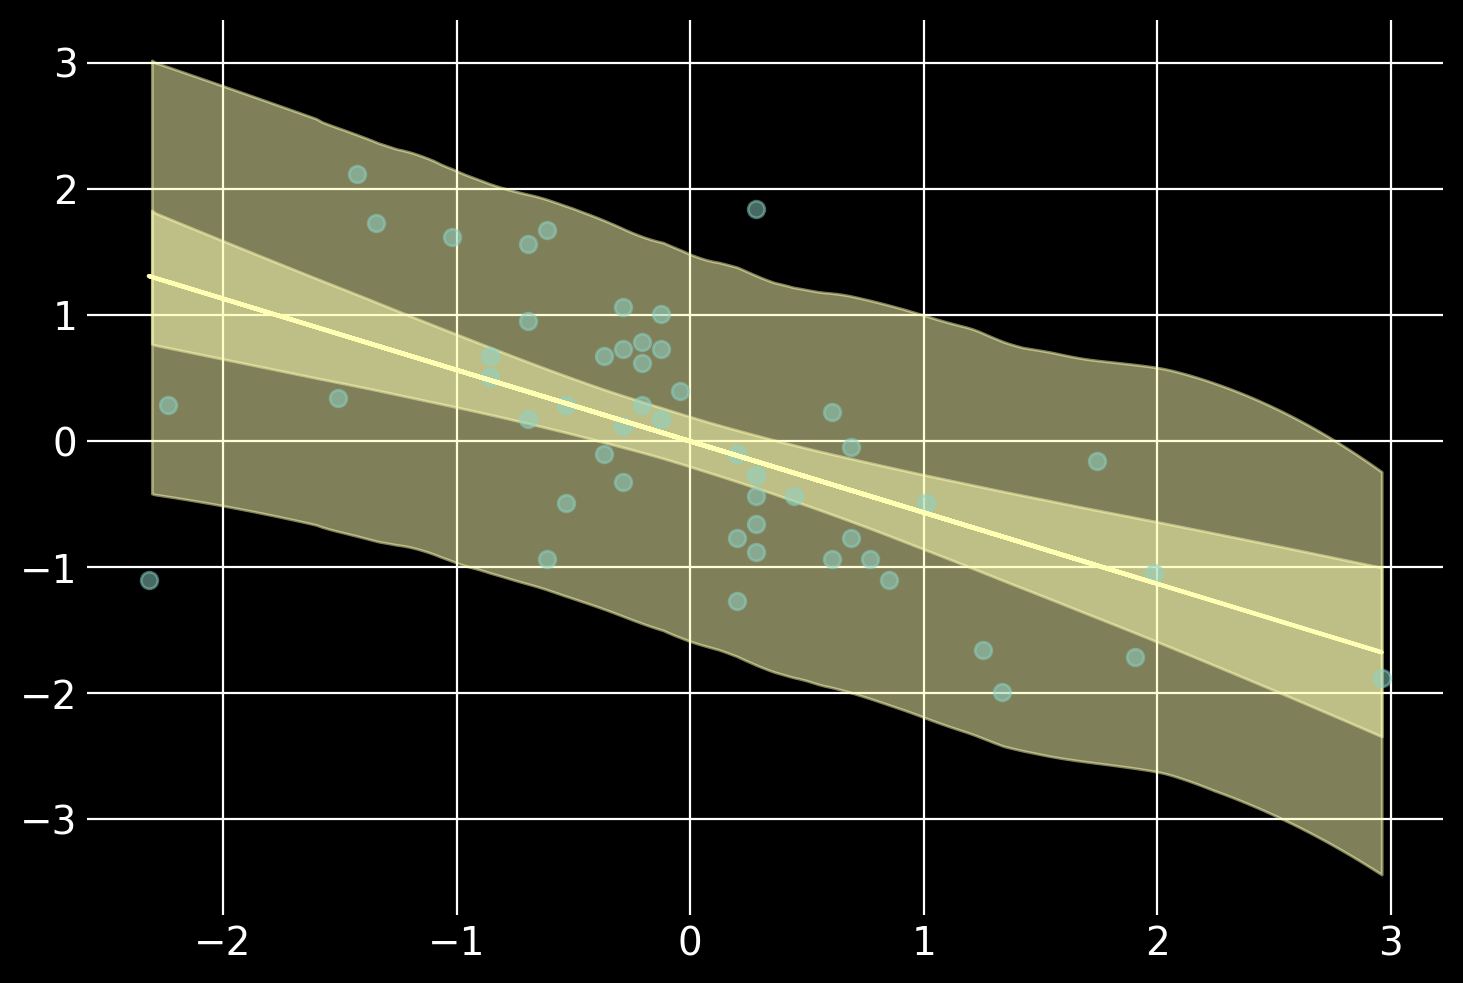

In [368]:
_,ax = plt.subplots()
az.plot_hdi(medianAge, mu_post, ax=ax)
az.plot_hdi(medianAge, div_post_pred, ax=ax)
ax.plot(medianAge,divObs,"o",alpha=0.5)
ax.plot(medianAge,mu_mean)

In [369]:
with pm.Model() as m5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s",1)
    mu = pm.Deterministic("mu", a + bM * marRate)
    div_rate = pm.Normal("div_rate", mu, s, observed=divObs)
    prior_samples = pm.sample_prior_predictive(samples=1000)
    trace5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, s]


/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bM'}>,
        <AxesSubplot:title={'center':'bM'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>]], dtype=object)

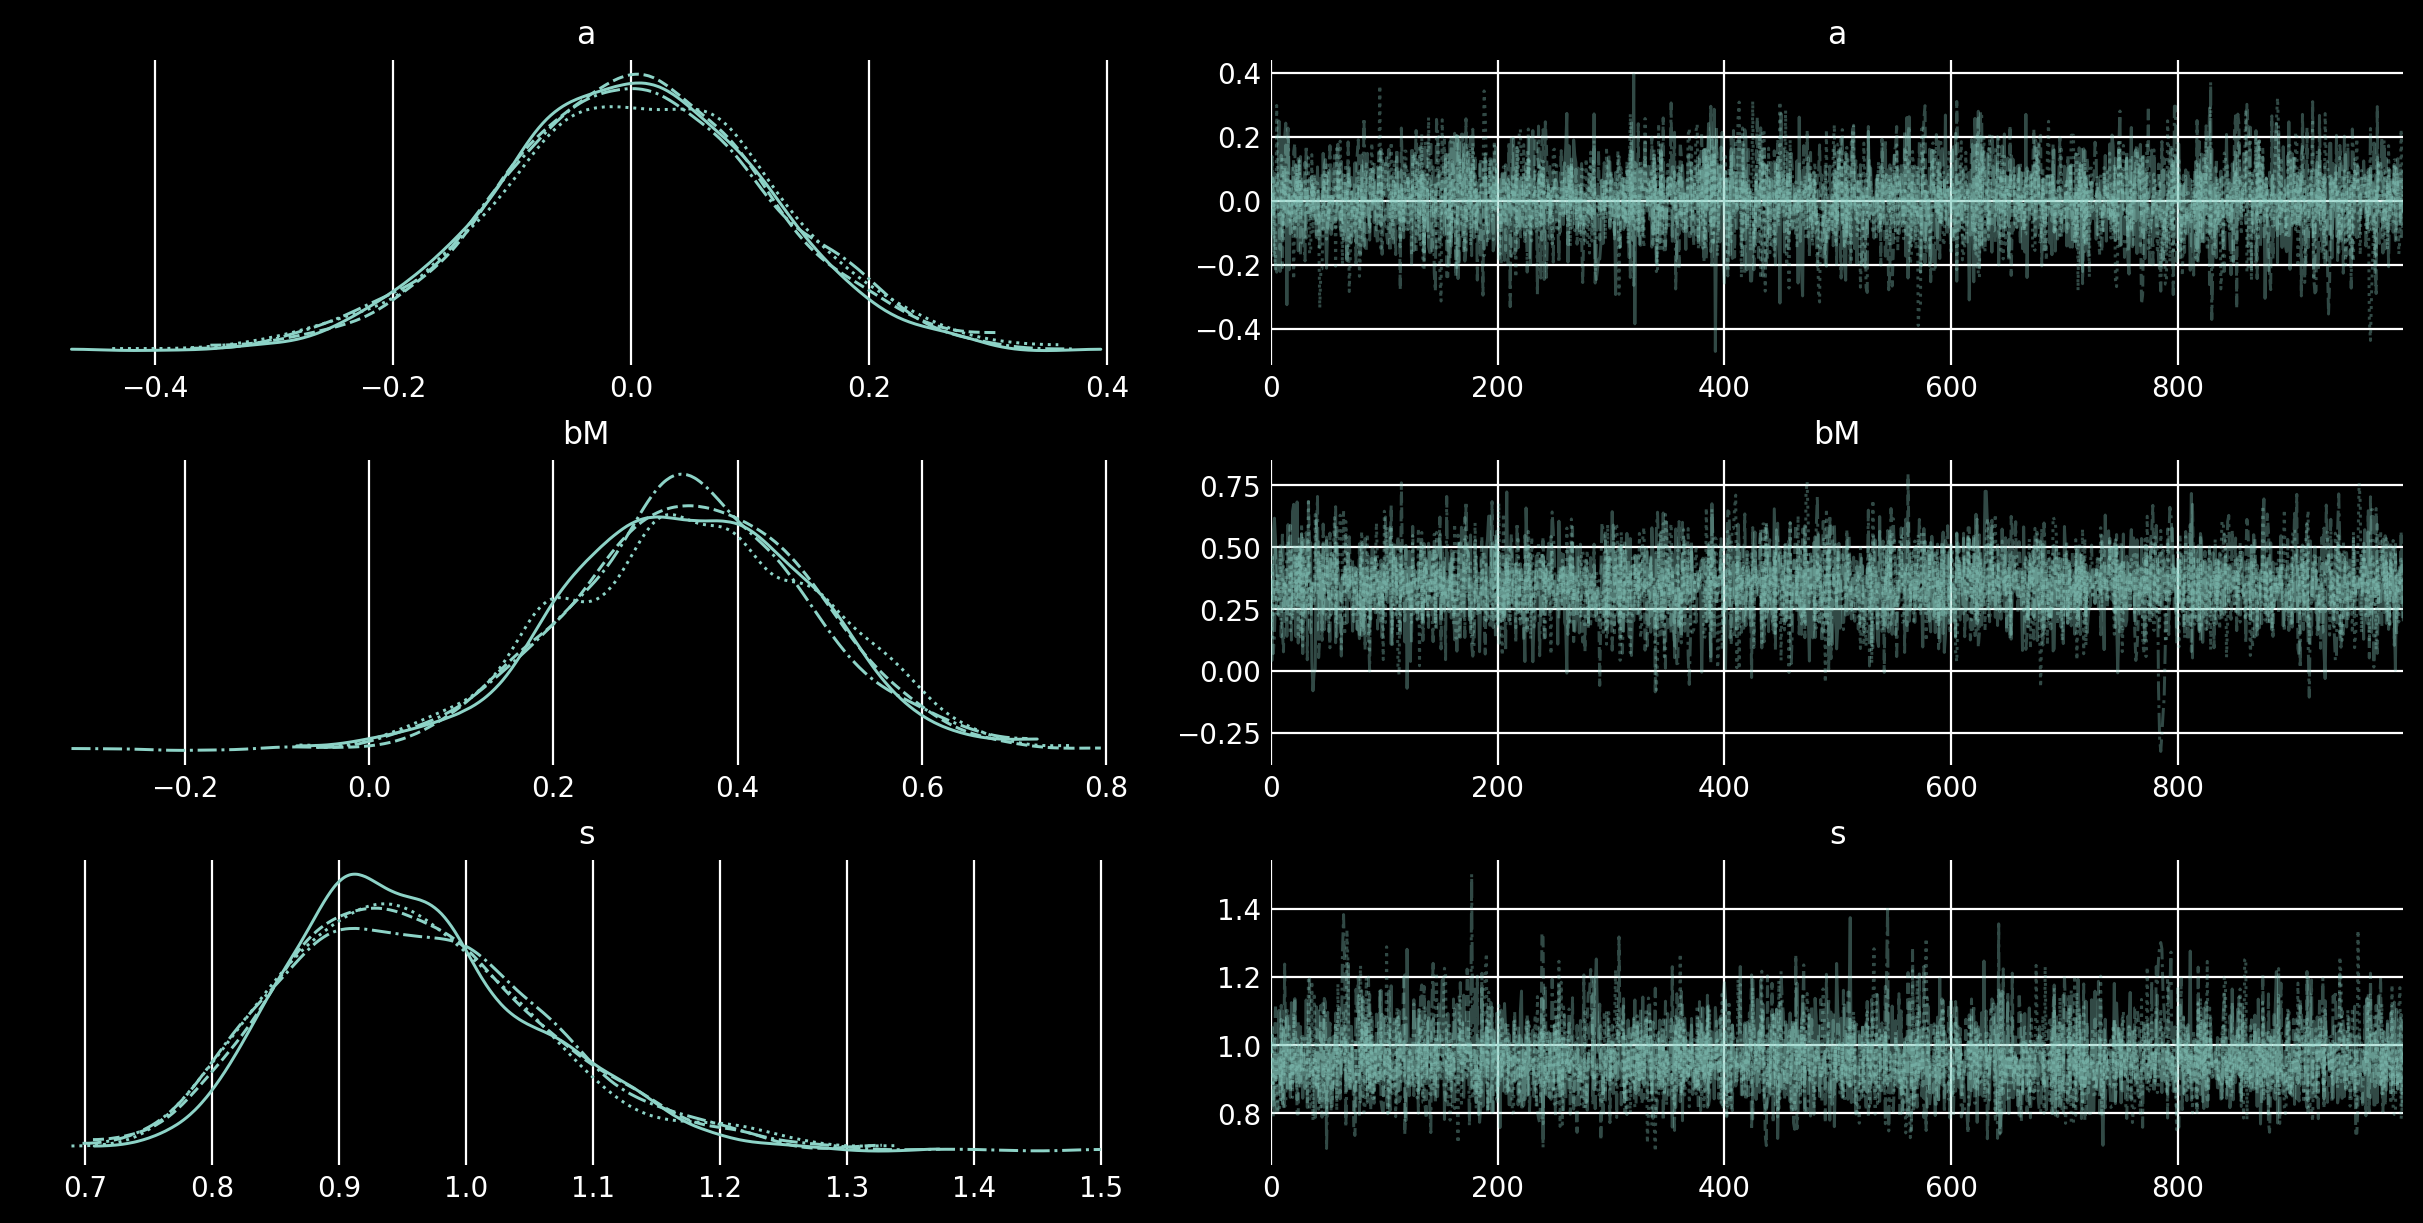

In [371]:
az.plot_trace(trace5_2, ["~mu"])

/var/folders/8p/pvxyj07903v98z897cyy14cm0000gp/T/ipykernel_88647/3737247718.py:3: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  post_samp = pm.sample_posterior_predictive(trace5_2, 1000, m5_2)


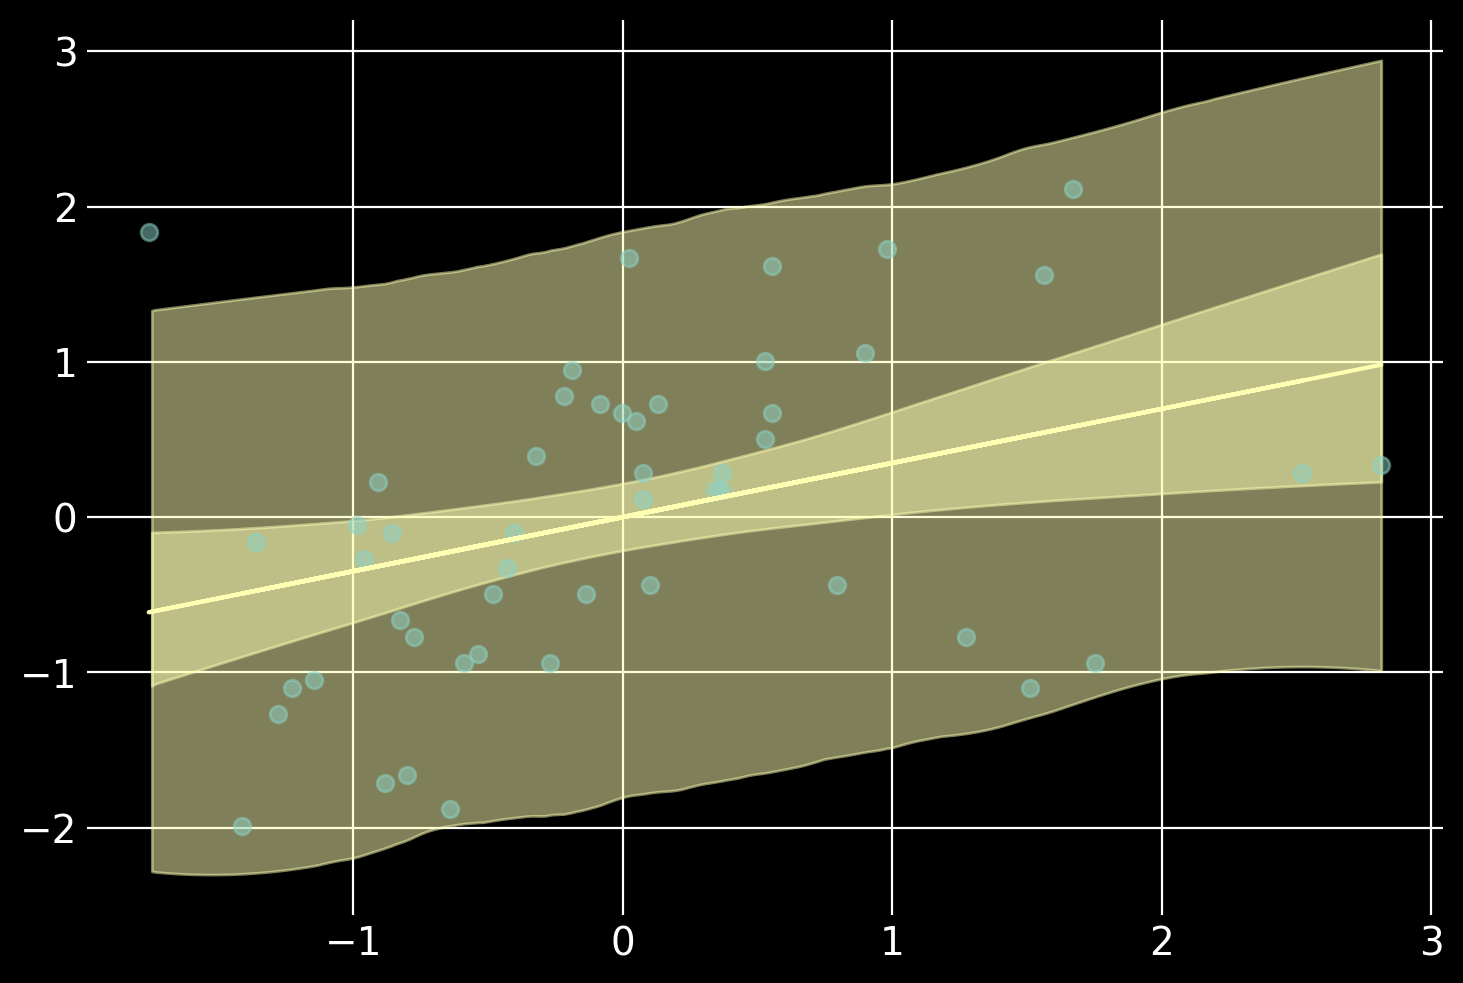

In [373]:
mu_post = trace5_2.posterior["mu"]
mu_mean = mu_post.mean(axis=(0,1))
post_samp = pm.sample_posterior_predictive(trace5_2, 1000, m5_2)
div_post_pred = post_samp.posterior_predictive["div_rate"]

_, ax = plt.subplots()
az.plot_hdi(marRate, mu_post, ax=ax)
az.plot_hdi(marRate, div_post_pred, ax=ax)
ax.plot(marRate, divObs, "o", alpha=0.5)
ax.plot(marRate, mu_mean)

In [399]:
with pm.Model() as m5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bA * medianAge + bM * marRate)
    div_rate = pm.Normal("div_rate", mu, s, observed=divObs)
    prior_samples = pm.sample_prior_predictive(samples=10000)
    trace5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, s]


/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bA'}>,
        <AxesSubplot:title={'center':'bA'}>],
       [<AxesSubplot:title={'center':'bM'}>,
        <AxesSubplot:title={'center':'bM'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>]], dtype=object)

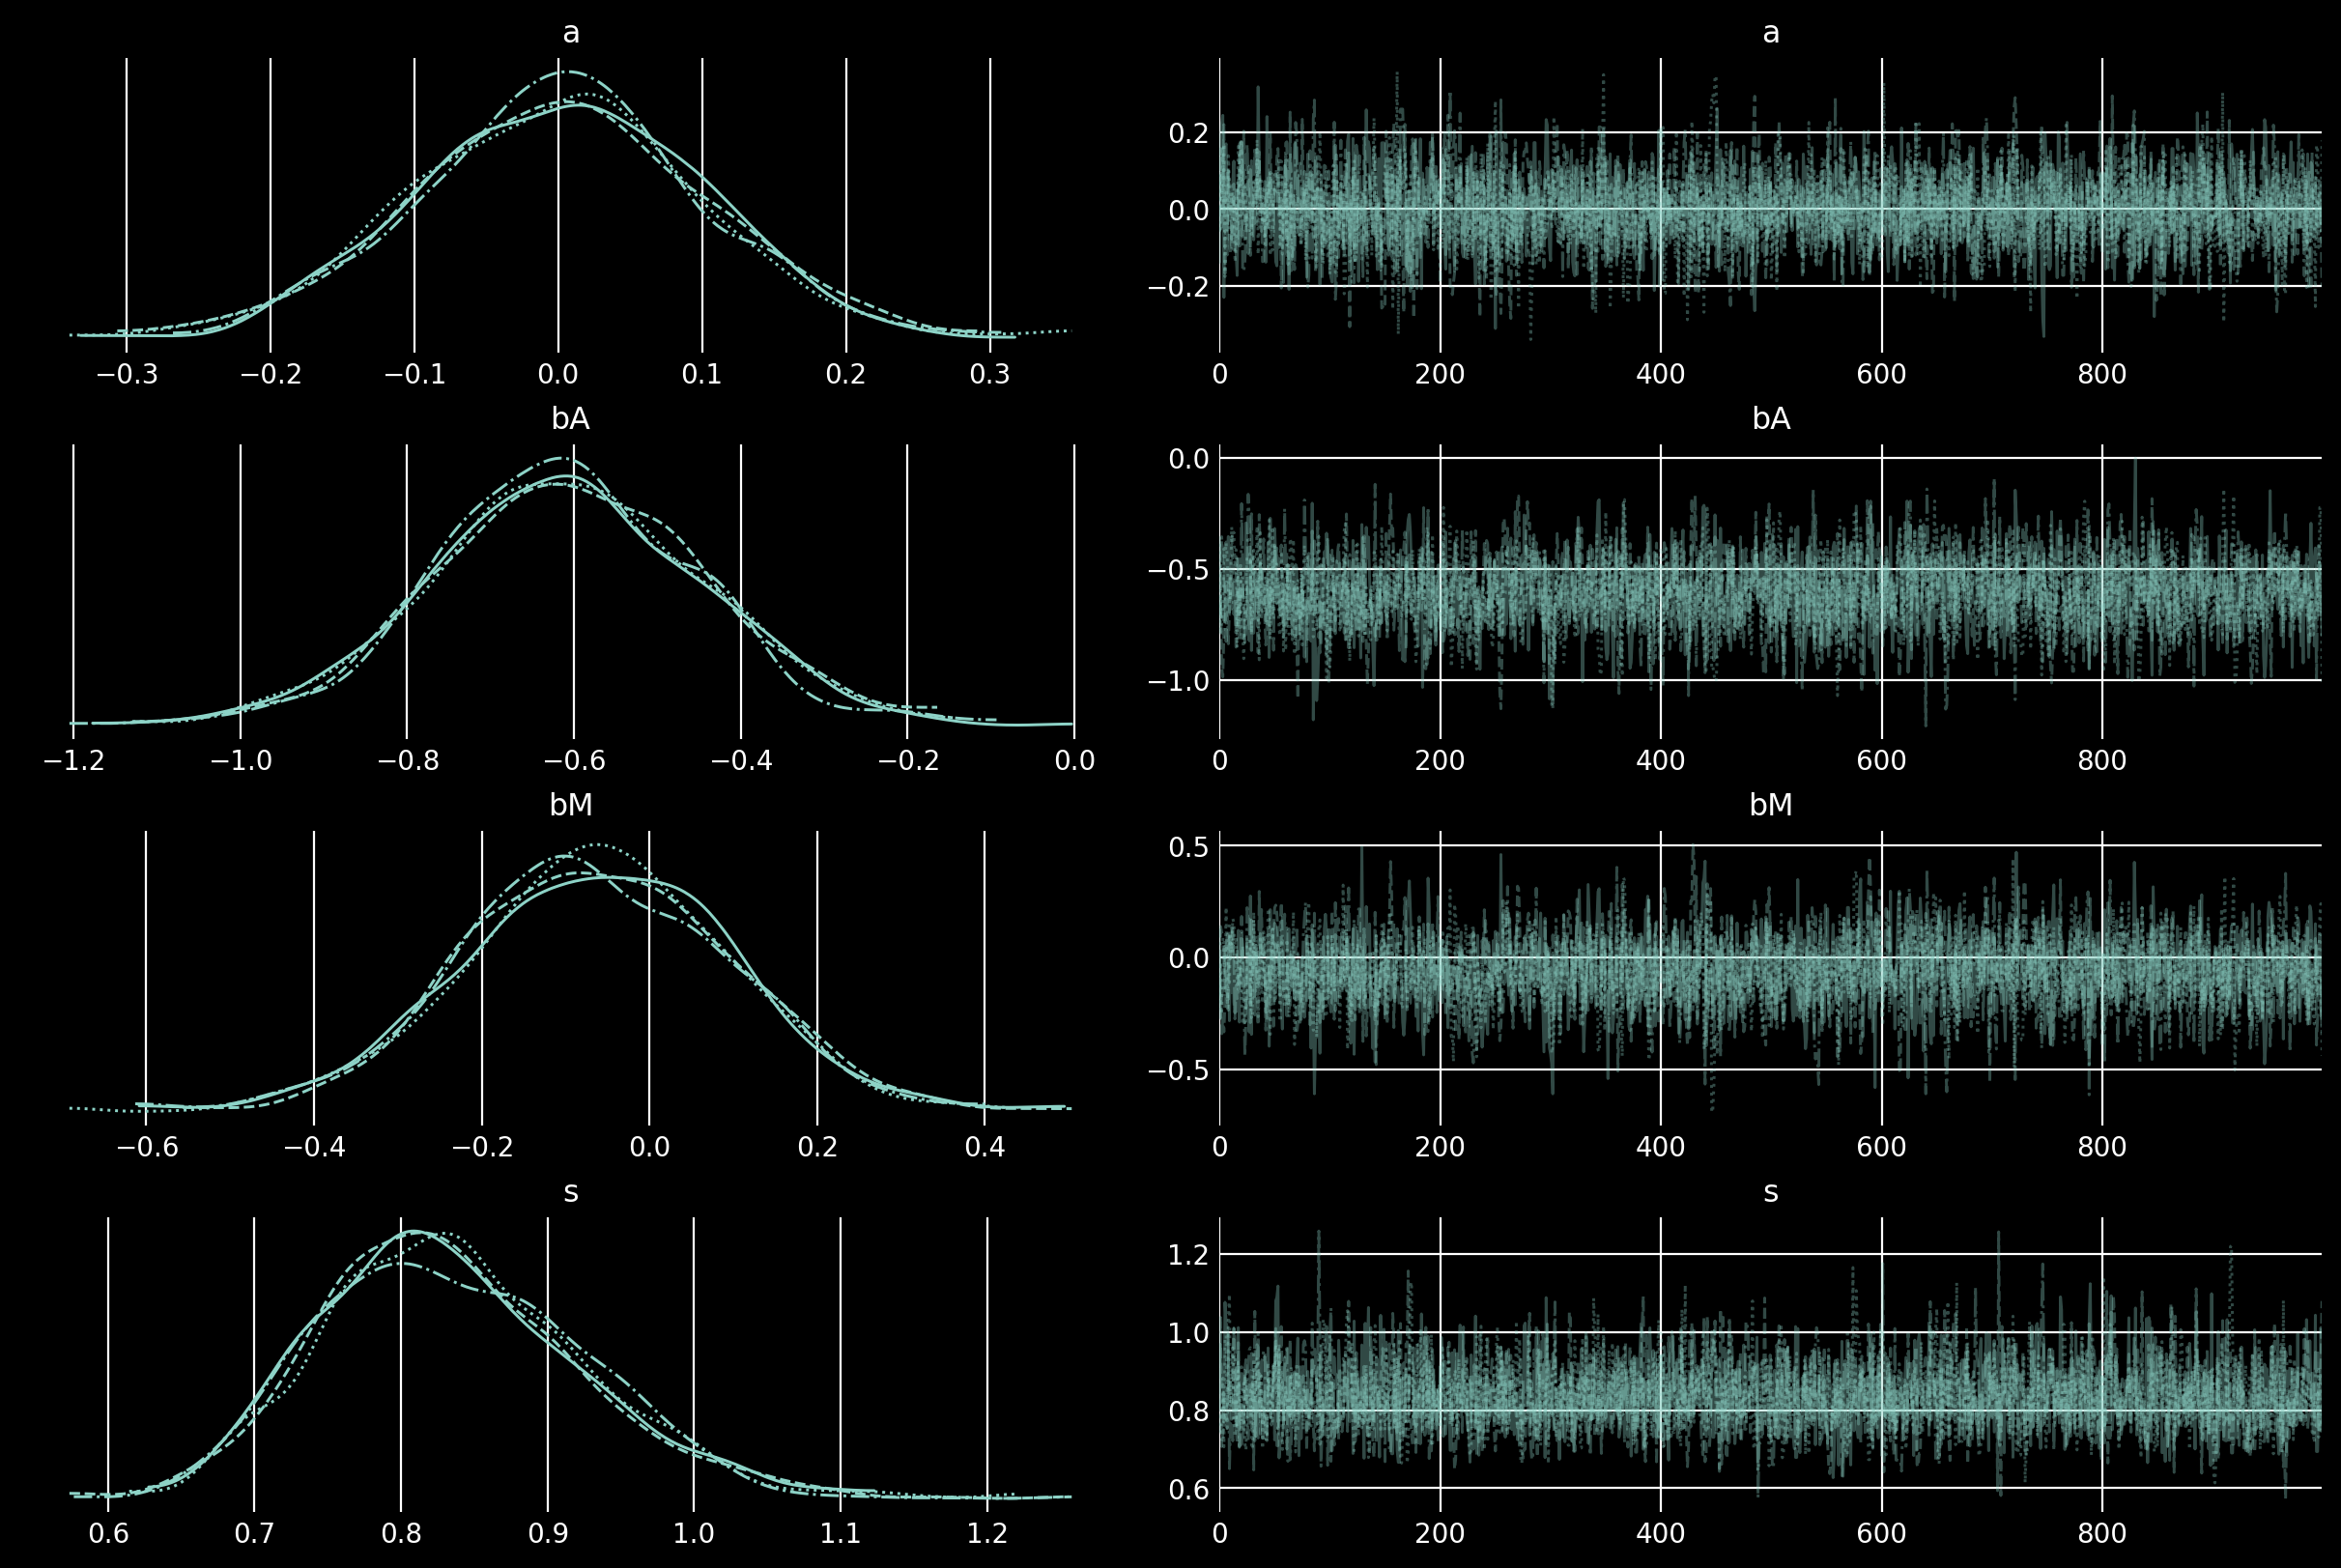

In [400]:
az.plot_trace(trace5_3, var_names=["~mu"])

In [403]:
az.summary(trace5_3, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a   0.001  0.100  -0.197    0.176      0.002    0.002    3332.0    2374.0   
bA -0.609  0.161  -0.901   -0.291      0.003    0.002    2503.0    2473.0   
bM -0.063  0.161  -0.359    0.239      0.003    0.003    2531.0    2174.0   
s   0.834  0.089   0.677    1.001      0.002    0.001    2885.0    2449.0   

    r_hat  
a     1.0  
bA    1.0  
bM    1.0  
s     1.0

marRate only has an effect on divRate in models missing age

marRate and divRate are conditionally independent given age

A -> M, A -> D

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

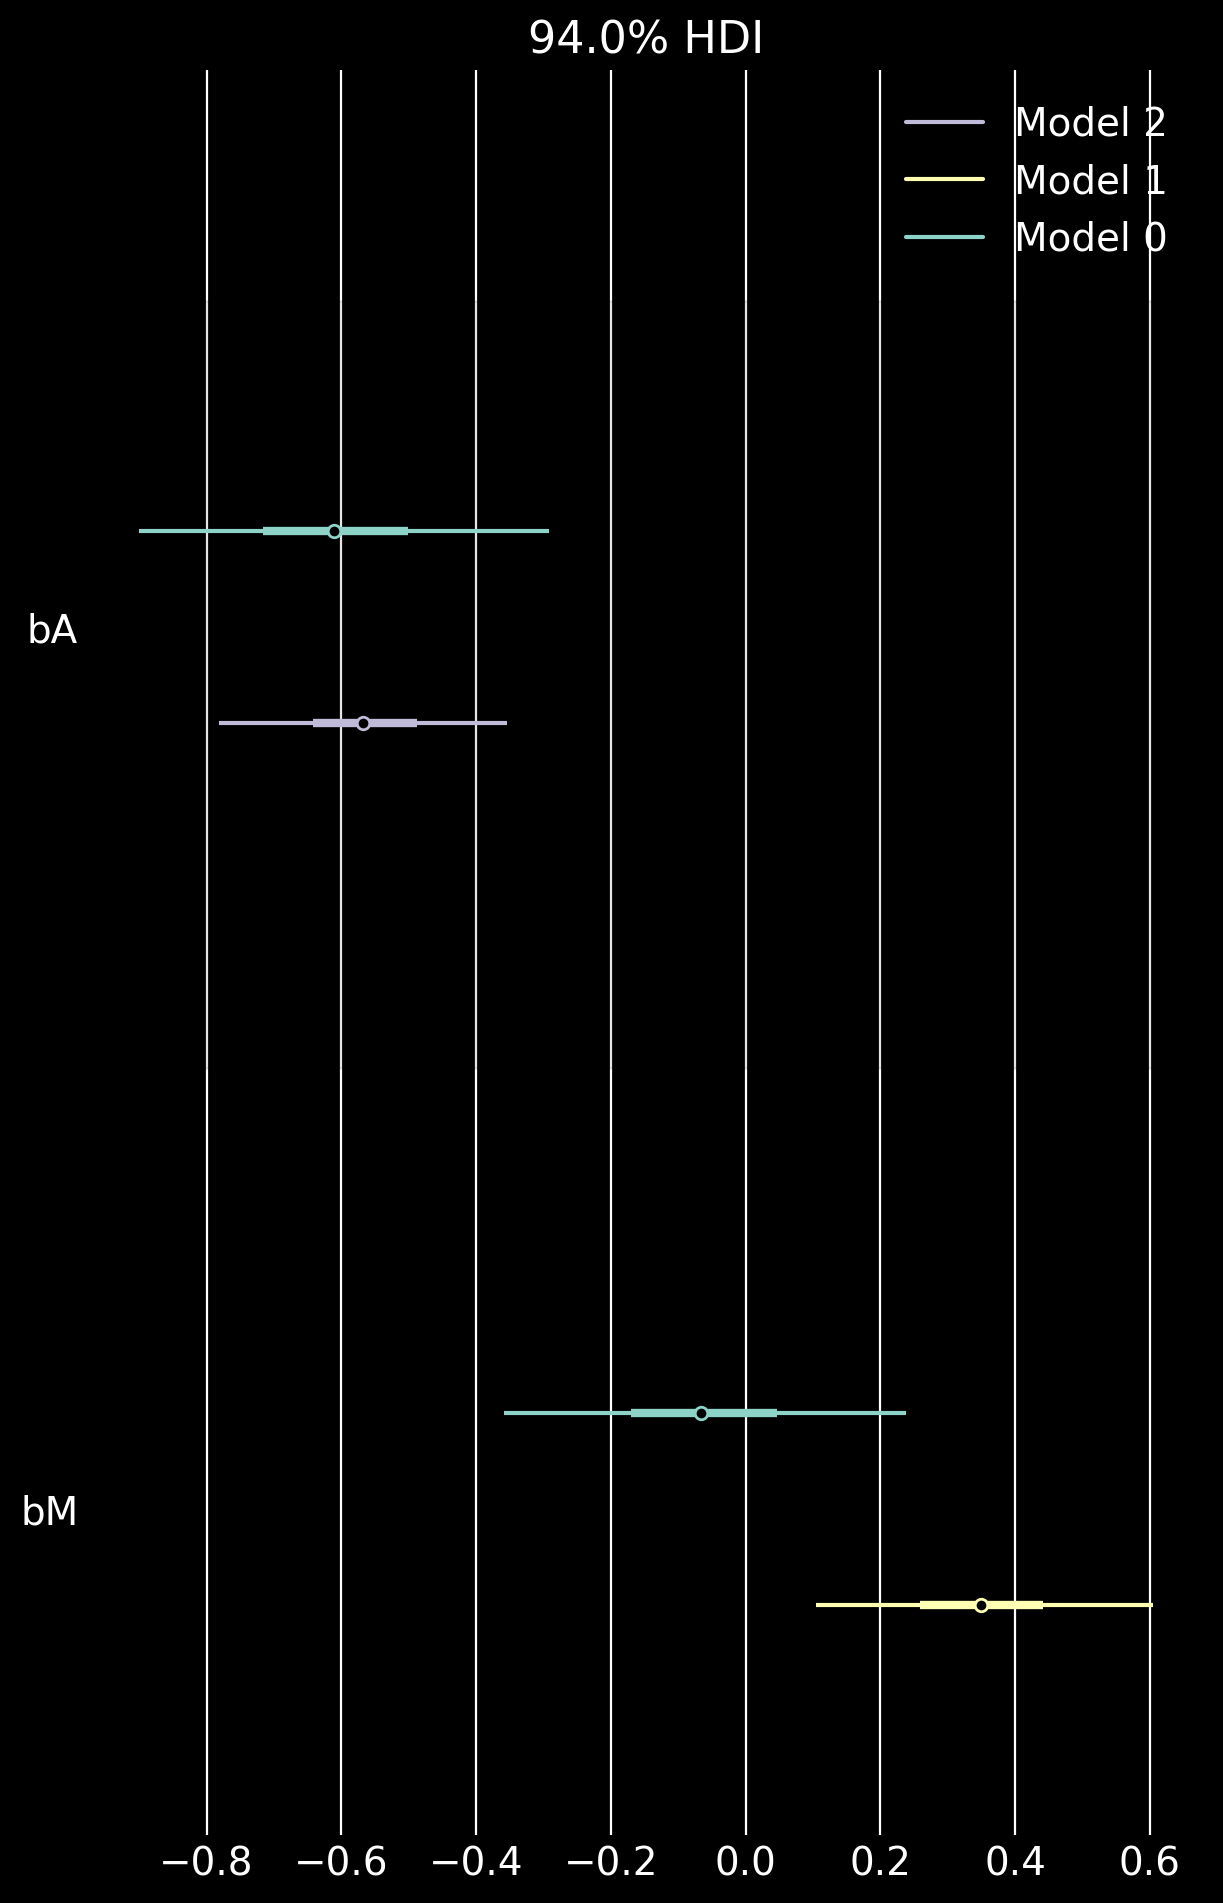

In [404]:
az.plot_forest([trace5_3,trace5_2,trace5_1], var_names=["bA", "bM"], combined=True)